In [2]:
import pandas as pd
import numpy as np
from scipy import signal
from scipy.fftpack import fft, ifft, fftfreq
import stumpy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import glob

### Read data
- some files need to use sep='\s+' to read and transpose

In [3]:
data_path = "./data-sets/KDD-Cup/data/*"
path_list = glob.glob(data_path)
file_names = {p.split("data/")[1].split("_")[0] : p  for p in path_list}

In [63]:
def read_data(file_id):
    
    file_path = file_names[file_id]
    
    if file_id in ["204","205", "206", "207", "208", "225","226", "242", "243"]:
        data = pd.read_csv(file_path, sep="\s+", header=None)
        data = data.T
    else:
        data = pd.read_csv(file_path, sep=",", header=None)

    point = int(file_path.split("_")[-1].split(".txt")[0])
    train = data.iloc[:point].reset_index(drop=True)
    test  = data.iloc[point:].reset_index(drop=True)
    
    return data, train, test, point

In [64]:
file_id = "001"
data, train, test, point = read_data(file_id)

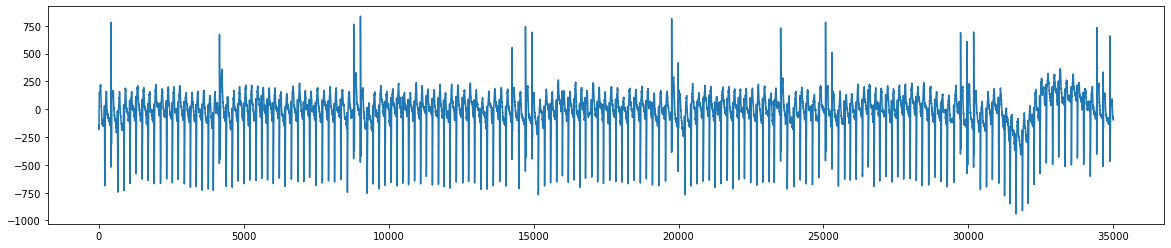

In [6]:
fig, ax = plt.subplots()
train.plot(legend=False, ax=ax, figsize=(20,4))
plt.show()

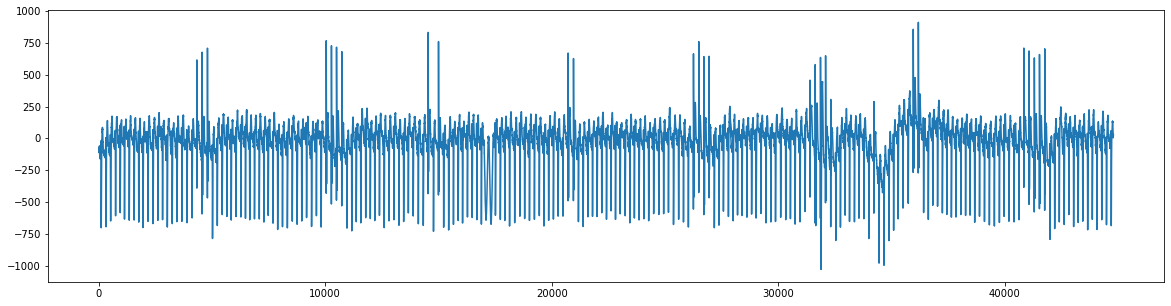

In [7]:
fig, ax = plt.subplots()
test.plot(legend=False, ax=ax, figsize=(20,5))
plt.show()

### Auto period finder
- find the window size for each time series

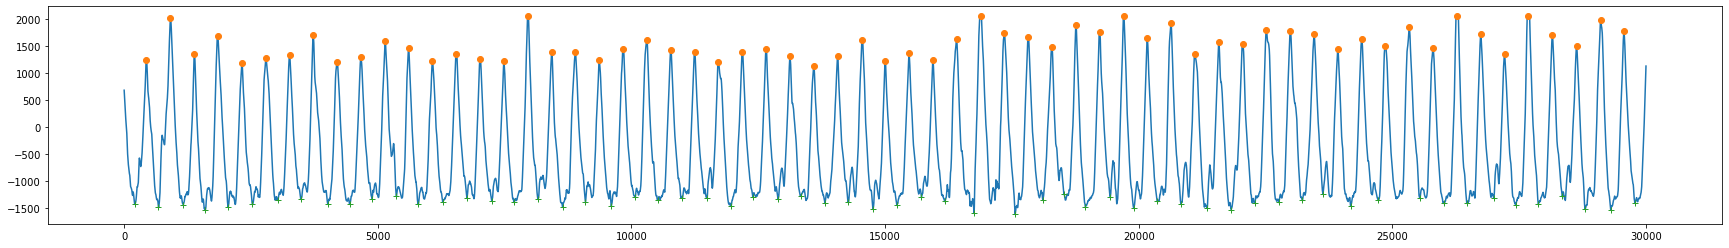

In [79]:
plt.figure(figsize=(30,4))
plt.plot(np.arange(len(train)),train)

a = signal.find_peaks(train.values.reshape(-1), distance=400)[0]
plt.plot(a, train.iloc[a],'o')

b = signal.find_peaks(-1*train.values.reshape(-1), distance=400)[0]
plt.plot(b, train.iloc[b],'+')
plt.show()

In [8]:
def find_period(arr, candidate_d):
    """
    @param arr: time series
    @param candidate_d: range to search for d
    """
    scores = []
    
    for d in candidate_d:
        peaks = signal.find_peaks(arr.reshape(-1), distance=d)[0] 
        valleys = signal.find_peaks(-arr.reshape(-1), distance=d)[0] 
        # calculate interval lengths pd and vd from peaks and valleys
        pd = np.mean(np.diff(peaks))
        vd = np.mean(np.diff(valleys))
        s_d = min(pd, vd) / np.sqrt(d)
        scores.append([d, s_d])
    
    # find argmin scores
    idx = np.argmin(np.array(scores)[:,1])
    return scores[idx][0]

In [9]:
# increase from 40 to 767, with a rate of 10%
candidate_d = [int(40*(1.1**i)) for i in range(32)]

In [10]:
# for file_id in file_ids[205:]:
file_id = "001"
data, train, test = read_data(file_id)

print("file id: %s" % file_id)
print(find_period(train.values, candidate_d))

file id: 001
40


### Fourier Transformation
- low-pass filter: remove noise
- high-pass filter: extract noise
- smoothing: remove noise or twisted frequency signals
- 但用了傅立叶变换后时间序列无变化

In [57]:
fft_train = fft(train, w) 

In [59]:
fft_train.shape

(35000, 767)

/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


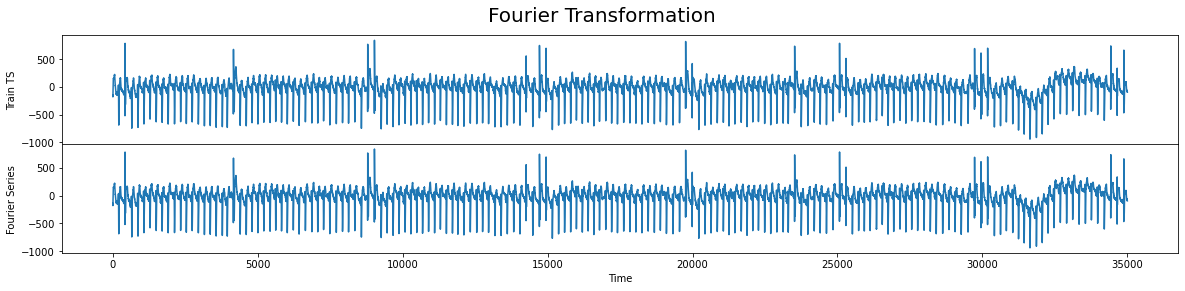

In [67]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(20,4))
plt.suptitle('Fourier Transformation', fontsize='20')

axs[0].plot(train.values)
axs[0].set_ylabel('Train TS', fontsize='10')

axs[1].set_xlabel('Time', fontsize ='10')
axs[1].set_ylabel('Fourier Series', fontsize='10')
axs[1].plot(fft_train[:,100])
plt.show()

### Score Functions

In [11]:
def smoothing(arr, w):
    """
    @param arr: time series
    @param w: window size
    return the smoothing scores
    """
    smooth_arr = arr.rolling(window=w, min_periods=w).mean().dropna()
    return smooth_arr

def compute_confidence_score(s):
    """
    @param s: score dataframe
    return the ratio of first peak and second peak
    """
    peak_1 = signal.find_peaks(s.values.reshape(-1), distance=len(s))[0]
    s1 = s.iloc[peak_1]

    # find peak_2 except for this interval [peak_1 - w, peak_1 + w)
    s.iloc[peak_1[0]-w : peak_1[0]+w] = float(np.min(s))
    peak_2 = signal.find_peaks(s.values.reshape(-1), distance=len(s))[0]

    s2 = s.iloc[peak_2]
    ratio = s1.values/s2.values
    
    return ratio[0][0], peak_1[0]

#### peak-to-peak value
- orig_p2p: original time series
- diff: first-order diff
- acc: second-order diff
- orig_p2p_inv: inverse of original time series

In [114]:
def peak_to_peak_value(arr, w):
    """
    @param arr: dataframe of time series
    @param w: window size
    apply the smoothed score in dataframe
    """
    slide_max = arr.rolling(window=w, min_periods=w).max().dropna()
    slide_min = arr.rolling(window=w, min_periods=w).min().dropna()
    s = slide_max - slide_min
    smooth_s = smoothing(s, w)
    
    conf, peak = compute_confidence_score(s)
    return conf, peak

def peak_to_peak_inv(arr, w):
    """
    calculate inverse of peak to peak value
    @param arr: dataframe of time series
    @param w: window size
    apply the smoothed score in dataframe
    """
    slide_max = arr.rolling(window=w, min_periods=w).max().dropna()
    slide_min = arr.rolling(window=w, min_periods=w).min().dropna()
    s = 1 / (slide_max - slide_min)
    smooth_s = smoothing(s, w)
    
    conf, peak = compute_confidence_score(smooth_s)
    return conf, peak

In [115]:
test_diff = test.diff(1).dropna()
test_acc = test_diff.diff(1).dropna()

In [118]:
p2p = {}

for w in candidate_d:
    conf, peak = peak_to_peak_value(test, w)
    p2p["%d, orig_p2p" % w] = {"confidence": conf, "peak": peak}    
    
    conf, peak = peak_to_peak_value(test_diff, w)
    p2p["%d, diff_p2p" % w] = {"confidence": conf, "peak": peak}
    
    conf, peak = peak_to_peak_value(test_acc, w)
    p2p["%d, acc_p2p" % w] = {"confidence": conf, "peak": peak}
    
    conf, peak = peak_to_peak_inv(test, w)
    p2p["%d, orig_p2p_inv" % w] = {"confidence": conf, "peak": peak}    
    
p2p_df = pd.DataFrame.from_dict(p2p, orient="index")
p2p_df.sort_values(["confidence"], ascending=False)

confidence   peak
40, orig_p2p         1.310609  31857
58, orig_p2p         1.310609  31848
167, orig_p2p        1.310609  31793
151, orig_p2p        1.310609  31801
138, orig_p2p        1.310609  31808
...                       ...    ...
58, orig_p2p_inv     1.002723  15735
767, orig_p2p_inv    1.001561  23668
697, diff_p2p        1.000841   9691
767, diff_p2p        1.000841   9656
114, orig_p2p_inv    1.000331  14771

[128 rows x 2 columns]

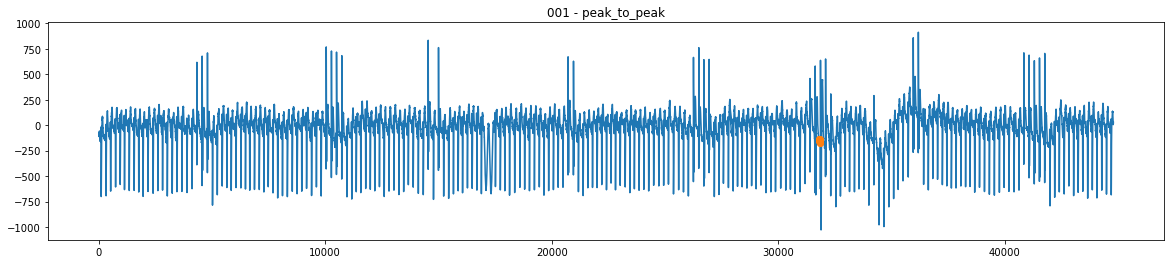

In [119]:
plt.figure(figsize=(20,4))
plt.plot(np.arange(len(test)),test)

a = np.array(p2p_df[p2p_df["confidence"] == p2p_df["confidence"].max()]["peak"])
a.sort()
plt.plot(a, test.iloc[a],'o')
plt.title("%s - peak_to_peak" % file_id)

plt.savefig("./picture/%s_p2p.jpg" % file_id)
plt.show()

#### Percentage of time when the absolute value of 1st order diff is small

#### sd of acc (2nd order diff) and inverse of sd of acc
- acc_std: 
- acc_std_inv:

In [108]:
def acc_std(arr, w):
    """
    standard deviation of 2nd order differential
    @param arr: time series
    @param w: window size
    """
    acc = arr.diff(1).dropna().diff(1).dropna()
    s = acc.rolling(window=w, min_periods=w).std().dropna()
    smooth_s = smoothing(s, w)
    conf, peak = compute_confidence_score(smooth_s)
    
    return conf, peak


def acc_std_inv(arr, w):
    """
    inverse of standard deviation of 2nd order differential
    @param arr: time series
    @param w: window size
    """
    acc = arr.diff(1).dropna().diff(1).dropna()
    s = acc.rolling(window=w, min_periods=w).std().dropna()
    s = 1/s
    smooth_s = smoothing(s, w)
    conf, peak = compute_confidence_score(smooth_s)
    
    return conf, peak

In [109]:
std = {}

for w in candidate_d:
    conf, peak = acc_std(test, w)
    std["%d, acc_std" % w] = {"confidence": conf, "peak": peak}    
    
    conf, peak = acc_std_inv(test, w)
    std["%d, acc_std_inv" % w] = {"confidence": conf, "peak": peak} 
    
std_df = pd.DataFrame.from_dict(std, orient="index")
std_df.sort_values(["confidence"], ascending=False)

confidence   peak
244, acc_std_inv    1.421183  16926
269, acc_std_inv    1.400818  16890
222, acc_std_inv    1.385889  16960
296, acc_std_inv    1.363371  16890
325, acc_std_inv    1.316293  16862
...                      ...    ...
183, acc_std        1.004268  26762
202, acc_std        1.004159  26743
697, acc_std        1.004011  26016
222, acc_std        1.003978  26723
767, acc_std        1.001070  40537

[64 rows x 2 columns]

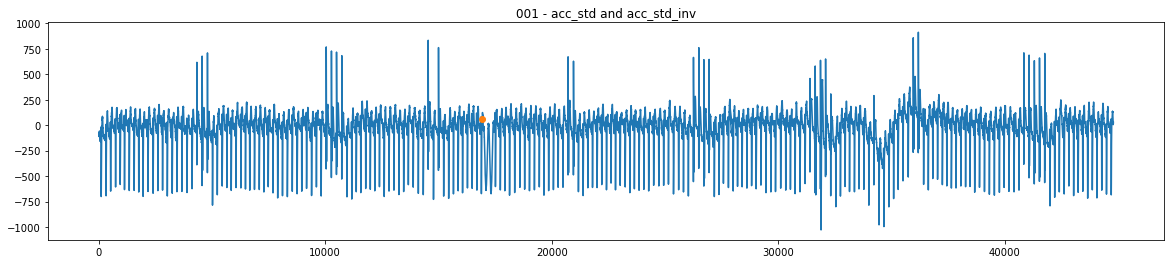

In [112]:
plt.figure(figsize=(20,4))
plt.plot(np.arange(len(test)),test)

a = np.array(std_df[std_df["confidence"] == std_df["confidence"].max()]["peak"])
a.sort()
plt.plot(a, test.iloc[a],'o')
plt.title("%s - acc_std and acc_std_inv" % file_id)

plt.savefig("./picture/%s_acc.jpg" % file_id)
plt.show()

#### Matrix Profile of origin
- self-join
- what if the discord index locates within the training data part? How to ensure that the discord index locates in the test dataset
- reference https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html

In [68]:
def origin_mp_outlier(arr, w, point):
    """
    use self-join version of matrix profile
    @param arr: time series, train + test
    @param w: window size
    @param point: cut-off point of train and test set
    """
    # (distance, neighbor_idx, , )
    mp = stumpy.stump(arr[0], w)
    mp_smooth = smoothing(pd.DataFrame(mp[:, 0]), w)
    ratio, peak = compute_confidence_score(mp_smooth[point:])
    return ratio, peak

In [69]:
ratio, peak = origin_mp_outlier(data, w, point)
print(ratio, peak)

1.1847670409740798 16577


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


- AB-join
- reference: https://stumpy.readthedocs.io/en/latest/Tutorial_AB_Joins.html

In [73]:
def orig_mp_novelty(train, test, w):
    """
    for every subsequence in test, find its furthest subsequence in train
    @param train: train time series
    @param test: test time series
    @param w: window size
    """
    ab_mp = stumpy.stump(T_A = test[0], m = w, T_B = train[0], ignore_trivial = False)
    mp_smooth = smoothing(pd.DataFrame(ab_mp[:, 0]), w)
    ratio, peak = compute_confidence_score(mp_smooth)
    return ratio, peak

In [74]:
ratio, peak = orig_mp_novelty(train, test, w)
print(ratio, peak)

1.1269507403224082 16574


In [84]:
mp = {}

for w in candidate_d:
    conf, peak = origin_mp_outlier(data, w, point)
    mp["%d, self-join" % w] = {"confidence": conf, "peak": peak}    
    
    conf, peak = orig_mp_novelty(train, test, w)
    mp["%d, ab-join" % w] = {"confidence": conf, "peak": peak}

mp_df = pd.DataFrame.from_dict(mp, orient="index")
mp_df.sort_values(["confidence"], ascending=False)

/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

confidence   peak
393, self-join    1.433036  16971
433, self-join    1.427118  16915
476, self-join    1.400813  16825
393, ab-join      1.390702  16971
358, ab-join      1.379465  17010
...                    ...    ...
94, ab-join       1.006637  17275
125, ab-join      1.002860  17261
40, ab-join       1.001532   6378
103, ab-join      1.000646  17263
58, ab-join       1.000013  18460

[64 rows x 2 columns]

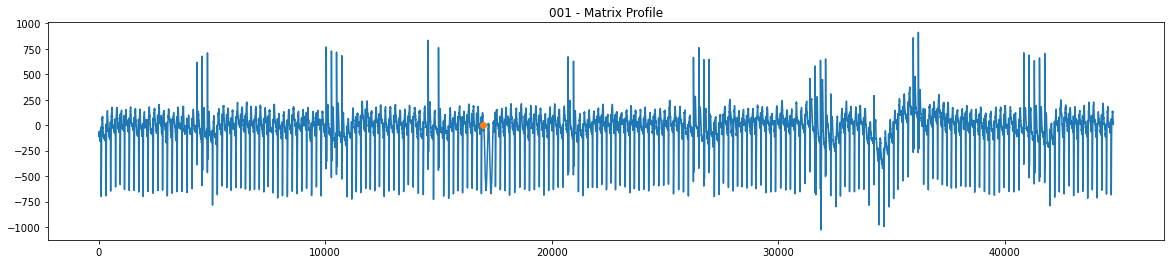

In [93]:
plt.figure(figsize=(20,4))
plt.plot(np.arange(len(test)),test)

a = np.array(mp_df[mp_df["confidence"] == mp_df["confidence"].max()]["peak"])
a.sort()
plt.plot(a, test.iloc[a],'o')
plt.title("%s - Matrix Profile" % file_id)

plt.savefig("./picture/%s_mp.jpg" % file_id)
plt.show()

#### Normalized Matrix Profile of origin
- AB-join
- self-join

- Trial of using Strumy

In [7]:
w = 40

# (distance, neighbor_index, )
mp = stumpy.stump(data[0], w)

In [40]:
mp_df = pd.DataFrame(mp)

In [41]:
mp_df.head()

0      1   2      3
0  0.330125  29739  -1  29739
1   0.33588  29740  -1  29740
2  0.339724  29741  -1  29741
3  0.363917  29742  -1  29742
4  0.397361  29743  -1  29743

- motif: smallest distance - most similar subsequence

In [16]:
motif_idx = np.argsort(mp[:, 0])[0]
nearest_neighbor_idx = mp[motif_idx, 1]

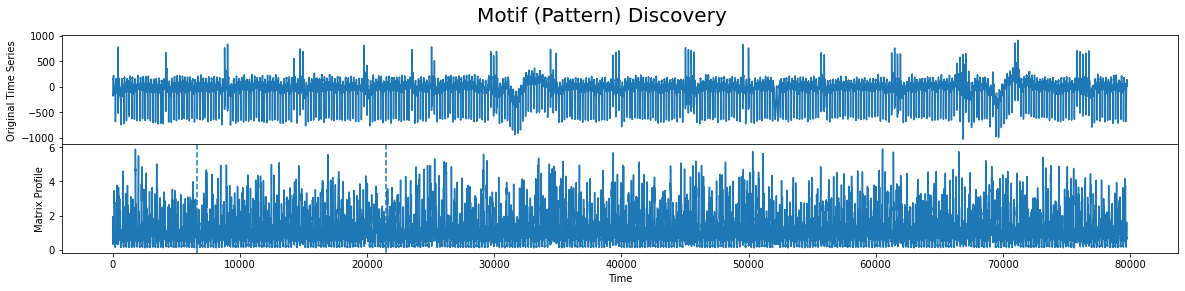

In [24]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(20,4))
plt.suptitle('Motif (Pattern) Discovery', fontsize='20')

axs[0].plot(data[0].values)
axs[0].set_ylabel('Original Time Series', fontsize='10')
rect = Rectangle((motif_idx, 0), w, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), w, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='10')
axs[1].set_ylabel('Matrix Profile', fontsize='10')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

- discord: largest distance

In [28]:
discord_idx = np.argsort(mp[:, 0])[-1]
nearest_neighbor_distance = mp[discord_idx, 0]

In [32]:
discord_idx

60540

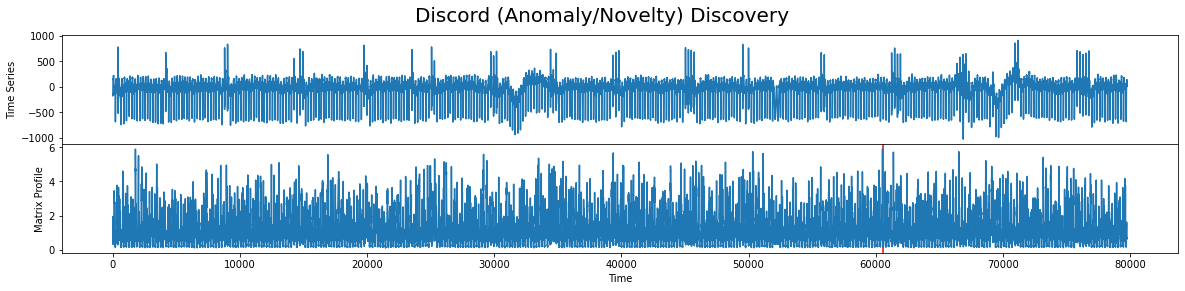

In [35]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(20,4))
plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='20')

axs[0].plot(data[0].values)
axs[0].set_ylabel('Time Series', fontsize='10')
rect = Rectangle((discord_idx, 0), w, 40, facecolor='red')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='10')
axs[1].set_ylabel('Matrix Profile', fontsize='10')
axs[1].axvline(x=discord_idx, c="red")
axs[1].plot(mp[:, 0])
plt.show()